#Modelos utilizados no TCC de João Pedro Santos :


Manutenção Preditiva de Máquinas Elétricas Utilizando Análise de Dados e Aprendizagem de Máquina

In [1]:
! pip install xgboost # modelo
! pip install scikit-optimize #ajuste de hiperparametros

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib
import seaborn as sns

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (12, 4)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
sns.set_style("darkgrid")

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/drive/MyDrive/dados TCC/ai4i2020.csv")

In [4]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
for column in df.columns:
    try:
        df[column]=df[column].astype(float)
    except:
        pass
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  float64
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  float64
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  float64
 8   Machine failure          10000 non-null  float64
 9   TWF                      10000 non-null  float64
 10  HDF                      10000 non-null  float64
 11  PWF                      10000 non-null  float64
 12  OSF                      10000 non-null  float64
 13  RNF                      10000 non-null  float64
dtypes: float64(12), object(

In [6]:
# removendo a classe de falhas aleatórias pq n faz sentido
df = df.drop(df[df['RNF'] == 1].index)
df.drop(['UDI','Product ID','RNF'],axis=1,inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF
0,M,298.1,308.6,1551.0,42.8,0.0,0.0,0.0,0.0,0.0,0.0
1,L,298.2,308.7,1408.0,46.3,3.0,0.0,0.0,0.0,0.0,0.0
2,L,298.1,308.5,1498.0,49.4,5.0,0.0,0.0,0.0,0.0,0.0
3,L,298.2,308.6,1433.0,39.5,7.0,0.0,0.0,0.0,0.0,0.0
4,L,298.2,308.7,1408.0,40.0,9.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# deixando tudo em uma unica coluna
df['Machine failure']= 0
df['Machine failure'][df['TWF']==1]=1
df['Machine failure'][df['HDF']==1]=2
df['Machine failure'][df['PWF']==1]=3
df['Machine failure'][df['OSF']==1]=4
#df['Machine failure'][df['RNF']==1]=5
df.drop(['TWF','HDF','PWF','OSF'],axis=1,inplace=True)  #,'RNF'],axis=1,inplace=True)

In [8]:
print('Classes:', df['Machine failure'].unique())
df.head()

Classes: [0 3 4 1 2]


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,308.6,1551.0,42.8,0.0,0
1,L,298.2,308.7,1408.0,46.3,3.0,0
2,L,298.1,308.5,1498.0,49.4,5.0,0
3,L,298.2,308.6,1433.0,39.5,7.0,0
4,L,298.2,308.7,1408.0,40.0,9.0,0


Engenharia de Features

In [9]:
#potencia
df['Power'] = df['Rotational speed [rpm]']*df['Torque [Nm]']
#desgaste por potencia
df['Power wear'] = df['Power']*df['Tool wear [min]']
# Diferença de temperatura
df['Temperature difference'] = df['Process temperature [K]']-df['Air temperature [K]']
# Razão da diferença de temperatura pela potencia
df['Temperature power'] = df['Temperature difference']/df['Power']
# Temperatura por tempo de desgaste
df['Temperature wear'] = df['Temperature difference'] * df['Tool wear [min]']
#Torque por diferença de temperatura
df['Temperature torque'] = df['Temperature difference']/df['Torque [Nm]']
#Torque em relação a potência aplicada
df['Torque power'] = df['Torque [Nm]']/df['Power']

In [10]:
df = df[['Air temperature [K]',
         'Process temperature [K]',
         'Rotational speed [rpm]',
         'Torque [Nm]',
         'Tool wear [min]',
         'Power',
         'Power wear',
         'Temperature difference',
         'Temperature power',
         'Temperature wear',
         'Temperature torque',
         'Torque power',
         'Type',
         'Machine failure'
        ]]

In [11]:
# get_dummies aplica o one hot encoder nos dados categoricos
df = pd.get_dummies(df,drop_first=True)

In [12]:
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Power,Power wear,Temperature difference,Temperature power,Temperature wear,Temperature torque,Torque power,Machine failure,Type_L,Type_M
0,298.1,308.6,1551.0,42.8,0.0,66382.8,0.0,10.5,0.000158,0.0,0.245327,0.000645,0,0,1
1,298.2,308.7,1408.0,46.3,3.0,65190.4,195571.2,10.5,0.000161,31.5,0.226782,0.000710,0,1,0
2,298.1,308.5,1498.0,49.4,5.0,74001.2,370006.0,10.4,0.000141,52.0,0.210526,0.000668,0,1,0
3,298.2,308.6,1433.0,39.5,7.0,56603.5,396224.5,10.4,0.000184,72.8,0.263291,0.000698,0,1,0
4,298.2,308.7,1408.0,40.0,9.0,56320.0,506880.0,10.5,0.000186,94.5,0.262500,0.000710,0,1,0


In [13]:
#verificando a qualidade dos dados pra ver se teve algum valor Na com as operações
df.isna().sum()

Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Power                      0
Power wear                 0
Temperature difference     0
Temperature power          0
Temperature wear           0
Temperature torque         0
Torque power               0
Machine failure            0
Type_L                     0
Type_M                     0
dtype: int64

Seleção de Features

In [14]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2
import plotly.graph_objects as go

best_features = SelectKBest(score_func=chi2,k='all')

X = df.drop('Machine failure',axis =1 ) # features
y = df['Machine failure'] # alvo


fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Melhores 20 Atributos",
                  height=500,
                  showlegend=False,
                 )

fig.show()

# Seleção de Features

In [15]:
# awesome bit of code from https://www.kaggle.com/code/adibouayjan/house-price-step-by-step-modeling

Selected_Features = []
import statsmodels.api as sm

def backward_regression(X, y, initial_list=[], threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")
    return Selected_Features

# Application of the backward regression function on our training data
sel = backward_regression(X, y)

worst_feature : Temperature wear, 0.5378922848566206 
worst_feature : Type_M, 0.4320074140942137 
worst_feature : Torque power, 0.122213001228914 

Selected Features:
['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Power', 'Power wear', 'Temperature difference', 'Temperature power', 'Temperature torque', 'Type_L']


In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

f_classif = SelectKBest(score_func= f_classif, k = 'all')
fit = f_classif.fit(X.values,y)

In [17]:
cols = fit.get_support(indices = True)
sel_columns = X.iloc[:,cols].columns
print(sel_columns)

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Power',
       'Power wear', 'Temperature difference', 'Temperature power',
       'Temperature wear', 'Temperature torque', 'Torque power', 'Type_L',
       'Type_M'],
      dtype='object')


In [18]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X.values, y)

scores = selector.scores_
indices = np.argsort(scores)[::-1]  # Obter os índices das features ordenados pelo score em ordem decrescente

ranking = []
for i in indices:
    ranking.append(X.columns[i])

print("Ranking das features:")
for rank, feature in enumerate(ranking, start=1):
    print(f"{rank}. {feature}")

Ranking das features:
1. Power wear
2. Temperature torque
3. Torque [Nm]
4. Power
5. Temperature power
6. Rotational speed [rpm]
7. Torque power
8. Tool wear [min]
9. Temperature wear
10. Temperature difference
11. Air temperature [K]
12. Type_L
13. Process temperature [K]
14. Type_M


In [19]:
X = df.drop('Machine failure',axis =1 ) # features
y = df['Machine failure'] # alvo
X=X[sel_columns]
X.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Power,Power wear,Temperature difference,Temperature power,Temperature wear,Temperature torque,Torque power,Type_L,Type_M
0,298.1,308.6,1551.0,42.8,0.0,66382.8,0.0,10.5,0.000158,0.0,0.245327,0.000645,0,1
1,298.2,308.7,1408.0,46.3,3.0,65190.4,195571.2,10.5,0.000161,31.5,0.226782,0.000710,1,0
2,298.1,308.5,1498.0,49.4,5.0,74001.2,370006.0,10.4,0.000141,52.0,0.210526,0.000668,1,0
3,298.2,308.6,1433.0,39.5,7.0,56603.5,396224.5,10.4,0.000184,72.8,0.263291,0.000698,1,0
4,298.2,308.7,1408.0,40.0,9.0,56320.0,506880.0,10.5,0.000186,94.5,0.262500,0.000710,1,0


#Metricas e preparação dos dados para os modelos

Há clusteres nos dados ?

In [20]:
from random import sample
from numpy.random import uniform
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import scale, normalize

# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X,k=2):
    try:
        X=X.drop(['Type_L','Type_M'],axis = 1,inplace=True).values  #convert dataframe to a numpy array
    except:
        pass
    # X = scale(X)
    X = normalize(X)
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures


    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))



    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]


    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs=neigh.fit(X)

    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=k)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour

    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=k)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]



    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)

    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

H=hopkins_statistic(X,3)
print('Hopkins statistic: '+str(H))

Hopkins statistic: 0.9999187282871279


# Decidindo a tecnica de oversample

Os dados estão muito desequilibrados, portanto, normalmente fazemos oversampling. Mas também há muitos dados na classe normal, o que sugere uma utilização de um metodo de undersample. Como o valor da estatistica que diz que há clusteres nas classes deu alta temos uma direção de que o metodo de oversample não vai alterar significantemente as regiões dos dados.

In [21]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 0,
                                                    stratify=y)
# Aplicando o SMOTE para fazer oversampling da classe minoritária

smote = SMOTE(random_state=42)
#smote = BorderlineSMOTE(random_state=42)
#smote = ADASYN(random_state=42)
#smote = SVMSMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_train,y_train)


# Aplicando o Tomek Links para fazer undersampling da classe majoritária
tomek = TomekLinks()
X_train, y_train = tomek.fit_resample(X_train, y_train)

# não temos nenhum outlier significativo, então uma simples normalização já é o suficiente
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
y_test.value_counts()

0    1931
2      21
4      20
3      17
1       8
Name: Machine failure, dtype: int64

In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score,matthews_corrcoef
from sklearn.metrics import confusion_matrix # calcula a matriz de confusão

import time
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','MCC score','time to train','time to predict','total time'])

#Criação dos Modelos

##KNN

Seleçao de hiperprametros

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Defina os parâmetros que deseja testar
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}

# Crie uma instância do modelo KNeighborsClassifier
knn = KNeighborsClassifier()

# Crie uma instância do GridSearchCV
grid_search = GridSearchCV(knn, param_grid)

# Ajuste o modelo usando o conjunto de treinamento
grid_search.fit(X_train, y_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)


Melhores parâmetros encontrados: {'n_neighbors': 3, 'weights': 'distance'}


Analise do desempenho do modelo

In [27]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
model = KNeighborsClassifier(n_neighbors=3, weights = 'distance').fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

In [28]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
# ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
# print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+"s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+"s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['KNN'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 94.24%
Recall: 94.24%
Precision: 97.62%
F1-Score: 95.60%
MCC: 53.36%
time to train: 0.25s
time to predict: 0.15s
total: 0.40 s


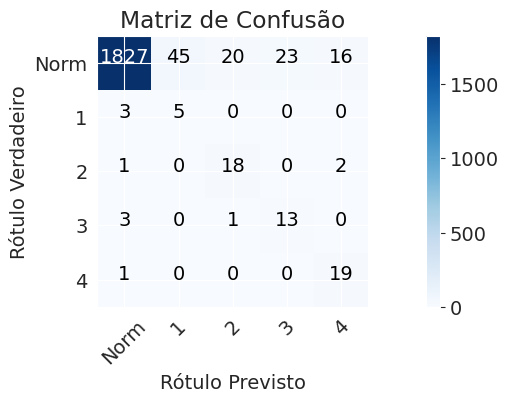

In [29]:
# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_predictions)

# Define as classes (rótulos)
classes = ['Norm', '1','2','3','4']

# Plota a matriz de confusão
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

# Adiciona os valores nas células da matriz
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1931
           1       0.10      0.62      0.17         8
           2       0.46      0.86      0.60        21
           3       0.36      0.76      0.49        17
           4       0.51      0.95      0.67        20

    accuracy                           0.94      1997
   macro avg       0.49      0.83      0.58      1997
weighted avg       0.98      0.94      0.96      1997



##Decision Tree

Seleção de hiperparâmetros

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Defina os parâmetros que deseja testar
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Crie uma instância do modelo DecisionTreeClassifier
dt = DecisionTreeClassifier()

# Crie uma instância do GridSearchCV
grid_search = GridSearchCV(dt, param_grid)

# Ajuste o modelo usando o conjunto de treinamento
grid_search.fit(X_train, y_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

Melhores parâmetros encontrados: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


Analisando o desempenho do modelo

In [ ]:
from sklearn.tree import DecisionTreeClassifier
start = time.time()
model = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, min_samples_leaf = 1, min_samples_split = 2).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
# ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
# print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Decision Tree'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

In [ ]:
# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_predictions)

# Define as classes (rótulos)
classes = ['Norm', '1','2','3','4']

# Plota a matriz de confusão
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

# Adiciona os valores nas células da matriz
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predictions))

In [ ]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feature_names = list(X.columns)
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predictions))

In [ ]:
#import graphviz
#from sklearn import tree
# DOT data
#dot_data = tree.export_graphviz(model, out_file=None,
 #                               feature_names=X.columns,
 #                               class_names=['None','TWF','HDF','PWF','OSF','RNF'],
 #                               filled=True,
#                                 size="5,5!"                              )
# Draw graph
#graph = graphviz.Source(dot_data, format="png")
#graph

## Random Forest

Selção de Hiperparâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Defina os parâmetros que deseja testar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crie uma instância do modelo RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=0)

# Crie uma instância do GridSearchCV
grid_search = GridSearchCV(rf, param_grid)

# Ajuste o modelo usando o conjunto de treinamento
grid_search.fit(X_train, y_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

Analisando o desempenho do modelo

In [ ]:
from sklearn.ensemble import RandomForestClassifier
start = time.time()
model = RandomForestClassifier(n_estimators = 100,n_jobs=-1,random_state=0,bootstrap=True,).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
# ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
# print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

In [ ]:
# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_predictions)

# Define as classes (rótulos)
classes = ['Norm', '1','2','3','4']

# Plota a matriz de confusão
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

# Adiciona os valores nas células da matriz
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

In [ ]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predictions))

## XGBoost

Seleção de Hiperparâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Defina os parâmetros que deseja testar
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Crie uma instância do modelo XGBClassifier
xgb_model = xgb.XGBClassifier()

# Crie uma instância do GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid)

# Ajuste o modelo usando o conjunto de treinamento
grid_search.fit(X_train, y_train)

# Obtenha os melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

Análise do desempenho do modelo

In [ ]:
import xgboost as xgb

start = time.time()
model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 300).fit(X_train, y_train)
end_train = time.time()

y_predictions = model.predict(X_test) # Estas são as previsões para os dados de teste.
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
# ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
# print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['XGBoost'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 98.45%
Recall: 98.45%
Precision: 99.21%
F1-Score: 98.78%
MCC: 79.88%
time to train: 99.15 s
time to predict: 0.04 s
total: 99.18 s


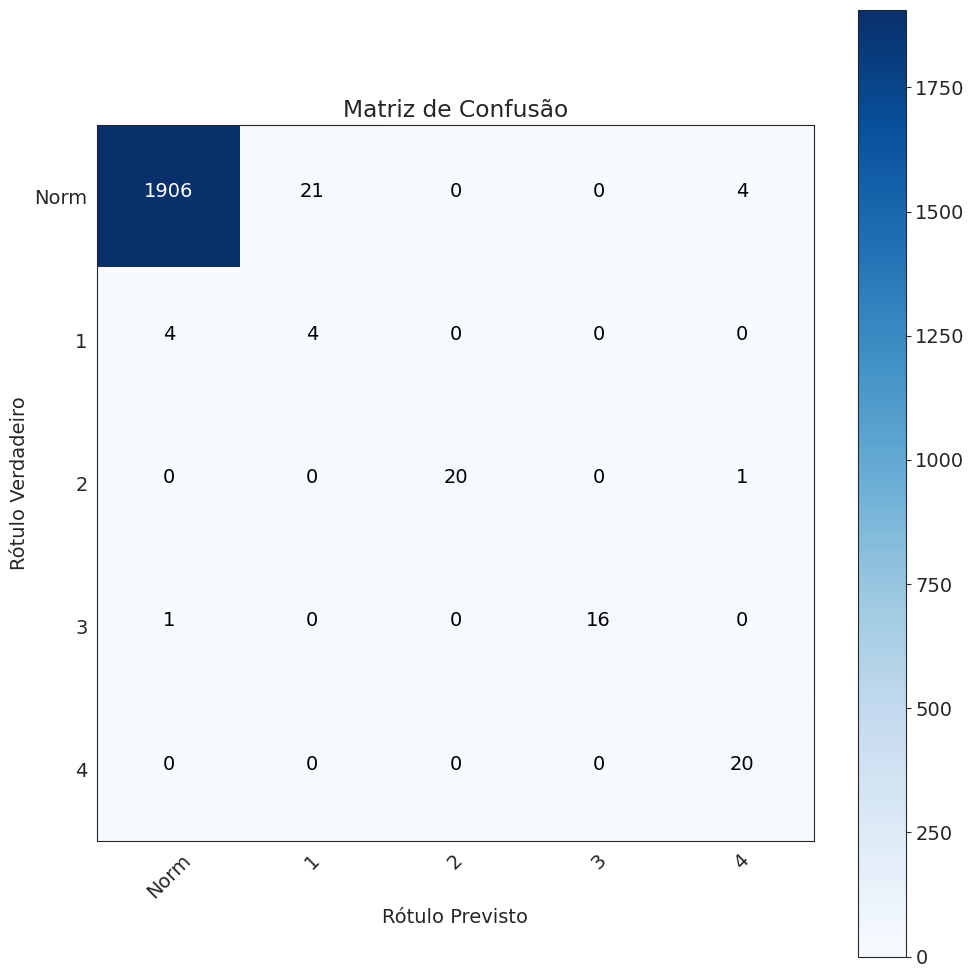

In [ ]:
# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_predictions)

# Define as classes (rótulos)
classes = ['Norm', '1','2','3','4']

# Plota a matriz de confusão
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

# Adiciona os valores nas células da matriz
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

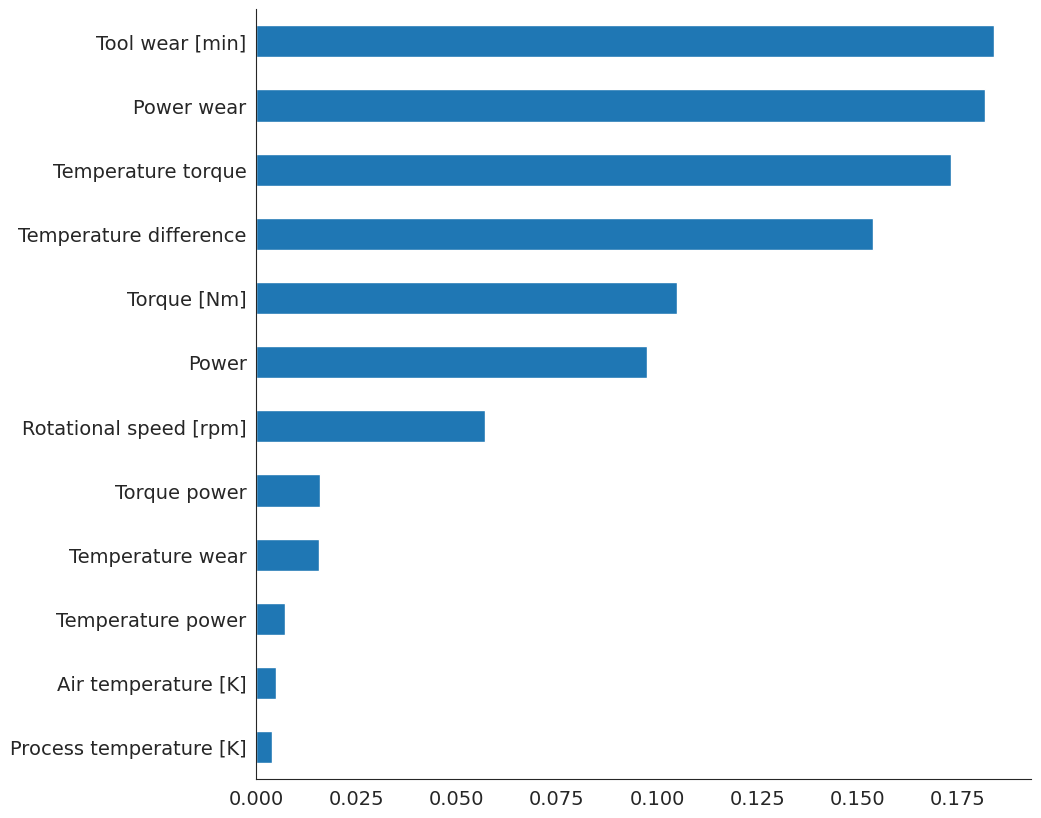

In [ ]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1931
           1       0.16      0.50      0.24         8
           2       1.00      0.95      0.98        21
           3       1.00      0.94      0.97        17
           4       0.80      1.00      0.89        20

    accuracy                           0.98      1997
   macro avg       0.79      0.88      0.81      1997
weighted avg       0.99      0.98      0.99      1997



# Validação

In [ ]:
model_performance.fillna(.90,inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'MCC score': '{:.2%}',
                                                                     'time to train':'{:.1f}',
                                                                     'time to predict':'{:.1f}',
                                                                     'total time':'{:.1f}',
                                                                     })

,Accuracy,Recall,Precision,F1-Score,MCC score,time to train,time to predict,total time
KNN,94.09%,94.09%,97.67%,95.54%,53.49%,0.1,0.1,0.2
Decision Tree,97.50%,97.50%,98.54%,97.96%,68.87%,0.9,0.0,0.9
Random Forest,97.60%,97.60%,98.74%,98.07%,72.75%,10.5,0.1,10.6
XGBoost,98.45%,98.45%,99.21%,98.78%,79.88%,99.1,0.0,99.2
